In [32]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt

current_dir = os.getcwd().split('/')[-1]
if current_dir != 'pixelNMF':
    os.chdir('..')

from patchnmf.analyse.nmf import cv_nmf

from kneed import DataGenerator, KneeLocator

'''

Load preprocessed array and run batch cross validation for NMF

The output n_components is then saved into pixelnmf_params.xls (TO DO automate save)

'''

'\n\nLoad preprocessed array and run batch cross validation for NMF\n\nThe output n_components is then saved into pixelnmf_params.xls (TO DO automate save)\n\n'

In [33]:
data_root_folder = r'C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels'

In [34]:
r_max = 50
step=2
replicates=1

In [35]:
data_root = r'C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels'

## cv_nmf_manual 

In [36]:
from sklearn.decomposition import NMF
import numpy as np
import itertools

def cv_nmf_sklearn(data, r_max, step, replicates, p_holdout=0.3, max_iter=10000, tol=1e-4):
    """
    Perform cross-validated NMF using scikit-learn's NMF implementation.
    
    Parameters:
    - data: Input dataset (2D array).
    - r_max: Maximum rank to test
    - step: Step size for ranks (e.g., test rank 10, 20, ..., r_max).
    - replicates: Number of replicates for each rank.
    - p_holdout: Proportion of data to hold out for testing (default 0.3).
    - max_iter: Maximum number of iterations for NMF (default 200).
    - tol: Tolerance for stopping criterion (default 1e-4).

    Returns:
    - train_err: List of training errors for each rank.
    - test_err: List of testing errors for each rank.
    """
    
    # Create ranks array
    ranks = np.arange(1, r_max, step)
    
    # Initialize error lists
    train_err = []
    test_err = []
    
    # Create a masking matrix for the missing data (1 = observed, 0 = held out)
    M = np.random.rand(*data.shape) > p_holdout
    masked_data = np.where(M, data, 0)
    
    # Loop through each rank and each replicate
    for rank, _ in itertools.product(ranks, range(replicates)):
        print(f"Fitting NMF with rank = {rank}")
        
        # Initialize and fit NMF model with scikit-learn
        model = NMF(n_components=rank, init='random', max_iter=max_iter, tol=tol, random_state=0)
        W = model.fit_transform(masked_data)
        H = model.components_
        
        # Reconstruct the data from the factorized matrices
        reconstructed_data = np.dot(W, H)
        
        # Calculate residual (difference between actual and reconstructed data)
        resid = reconstructed_data - data
        
        # Calculate training and testing errors
        train_err_r = np.mean(resid[M] ** 2)  # Only consider observed data in training
        test_err_r = np.mean(resid[~M] ** 2)  # Only consider held-out data in testing
        
        # Append the errors
        train_err.append((rank, train_err_r))
        test_err.append((rank, test_err_r))
        
        print(f"Finished running for rank: {rank} | Training error: {train_err_r:.4f}, Test error: {test_err_r:.4f}")

    return train_err, test_err

In [37]:
def plot_cv_opt(train_err, test_err, save_dir):
    train_err_np = np.array([te[1] for te in train_err])  # Extract train error values
    test_err_np = np.array([te[1] for te in test_err])    # Extract test error values
    ranks = np.array([te[0] for te in test_err])          # Extract rank values

    # Get the rank with the lowest test error
    n_nmf_min = np.argmin(test_err_np)

    # Find the elbow point using kneelocator 
    knee_locator = KneeLocator(ranks, test_err_np, curve="convex", direction="decreasing")
    n_nmf_elbow = knee_locator.knee

    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=200)
    ax.plot(ranks, train_err_np, 'o-', label='Train Data')
    ax.plot(ranks, test_err_np, 'o-', label='Test Data')
    ax.set_ylabel('MSE')
    ax.set_xlabel('Rank')
    ax.axvline(ranks[n_nmf_min], color='grey', dashes=[1,1.5], label='min')

    if n_nmf_elbow is not None:
        ax.axvline(n_nmf_elbow, color='black', dashes=[1,1.5], label='elbow') # or ranks[n_nmf_elbow]

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper right', fontsize=10)
    fig.tight_layout()
    plt.savefig(save_dir + 'cv_nmf.png')
    plt.show()

    return n_nmf_min, n_nmf_elbow

## run all cv_nmf

In [38]:
def cv_nmf_run_all(data_root):
    
    cv_dict = {}
    
    # iterate through all subdirectories in the data root folder
    for ds in os.listdir(data_root):
        ds_path = os.path.join(data_root, ds)
        
        # Check if the folder starts with 'sz'
        if ds.startswith("sz"):
            print(f"Processing folder: {ds}")
            
            # Path to the preprocessed 2D .npy file
            preprocessed_npy_file = os.path.join(ds_path, 'preprocessed_tiff.npy')
            
            # Check if the preprocessed .npy file exists
            if not os.path.exists(preprocessed_npy_file):
                print('Could not find preprocessed npy :/ ')
                continue
            
            # Load the preprocessed 2D numpy array
            try:
                tiff_flat = np.load(preprocessed_npy_file)
                print(f"Loaded preprocessed 2D numpy array for {ds}: {tiff_flat.shape}")
            except Exception as e:
                print(f"Error loading {preprocessed_npy_file}: {e}")
                continue
            
            # Run cv_nmf on the already flattened 2D data (no need to reshape)
            try:
                train_err, test_err = cv_nmf_sklearn(tiff_flat, r_max=50, step=2, replicates=1)

                save_path = os.path.join(ds_path, f'cv_{ds}.png')
                n_nmf_min, n_nmf_elbow = plot_cv_opt(train_err, test_err, save_dir=save_path) #save under ds and plot after done running

                cv_dict[ds] = {
                    'train_err' : train_err,
                    'test_err' : test_err,
                    'n_nmf_min': n_nmf_min, 
                    'n_nmf_elbow': n_nmf_elbow
                }
                            
            except Exception as e:
                print(f"Error during cv_nmf for {ds}: {e}")
                continue

    return cv_dict

In [46]:
def cv_nmf_run_all(data_root, selected_datasets=None):
    import os
    import numpy as np

    cv_dict = {}

    for root_folder in os.listdir(data_root):
        root_path = os.path.join(data_root, root_folder)

        if not os.path.isdir(root_path):
            continue

        for subfolder in os.listdir(root_path):
            ds = os.path.join(root_folder, subfolder)  # e.g., 'sz119/2025_06_08_b'
            ds_path = os.path.join(data_root, ds)

            normalized_ds = ds.replace("\\", "/")  # unify path separators
            
            if selected_datasets is not None and normalized_ds not in selected_datasets:
                continue  # Skip if not in the selected list

            for subroot, dirs, files in os.walk(ds_path):
                preprocessed_npy_file = os.path.join(subroot, 'preprocessed_tiff.npy')

                if not os.path.exists(preprocessed_npy_file):
                    print(f'❌ Could not find {preprocessed_npy_file}')
                    continue

                try:
                    tiff_flat = np.load(preprocessed_npy_file)
                    print(f"✅ Loaded preprocessed npy for {ds}: {tiff_flat.shape}")
                except Exception as e:
                    print(f"⚠️ Error loading {preprocessed_npy_file}: {e}")
                    continue

                try:
                    train_err, test_err = cv_nmf_sklearn(tiff_flat, r_max=50, step=2, replicates=1)
                    save_path = os.path.join(ds_path, f'cv_{subfolder}.png')
                    n_nmf_min, n_nmf_elbow = plot_cv_opt(train_err, test_err, save_dir=save_path)

                    cv_dict[ds] = {
                        'train_err': train_err,
                        'test_err': test_err,
                        'n_nmf_min': n_nmf_min,
                        'n_nmf_elbow': n_nmf_elbow
                    }

                except Exception as e:
                    print(f"❌ Error during cv_nmf for {ds}: {e}")
                    continue
    
    return cv_dict

In [47]:
os.listdir(data_root)

['sz004',
 'sz014',
 'sz015',
 'sz016',
 'sz018',
 'sz019',
 'sz020',
 'sz025',
 'sz026',
 'sz027',
 'sz030',
 'sz031',
 'sz034',
 'sz037',
 'sz038',
 'sz040',
 'sz080',
 'sz088',
 'sz089',
 'sz090',
 'sz091',
 'sz092',
 'sz095',
 'sz101',
 'sz116',
 'sz119']

In [52]:
selected = ['sz116/2025_06_07_d']

✅ Loaded preprocessed npy for sz116\2025_06_07_d: (3600, 12321)
Fitting NMF with rank = 1
Finished running for rank: 1 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 3
Finished running for rank: 3 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 5
Finished running for rank: 5 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 7
Finished running for rank: 7 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 9
Finished running for rank: 9 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 11
Finished running for rank: 11 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 13
Finished running for rank: 13 | Training error: 0.0000, Test error: 0.0001
Fitting NMF with rank = 15
Finished running for rank: 15 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 17
Finished running for rank: 17 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 19
F

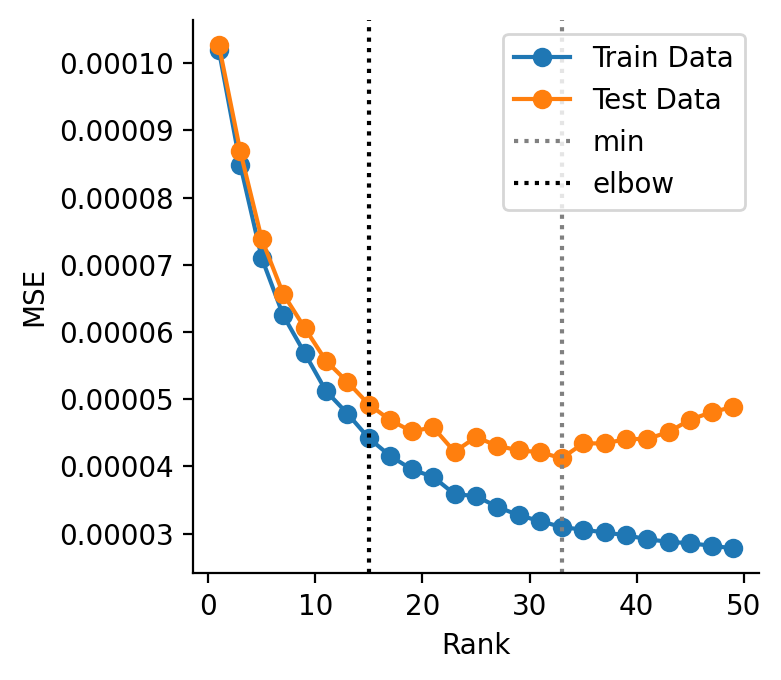

❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz116\2025_06_07_d\downsampled_tiff\preprocessed_tiff.npy
❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz116\2025_06_07_d\NMF\preprocessed_tiff.npy
❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz116\2025_06_07_d\NMF\nmf_final\preprocessed_tiff.npy
❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz116\2025_06_07_d\NMF\nmf_finalroi_to_fiji\preprocessed_tiff.npy
✅ Loaded preprocessed npy for sz116\2025_06_07_d: (3600, 12321)
Fitting NMF with rank = 1
Finished running for rank: 1 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 3
Finished running for rank: 3 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 5
Finished running for rank: 5 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 7
Finished running for rank: 7 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 9
Finish

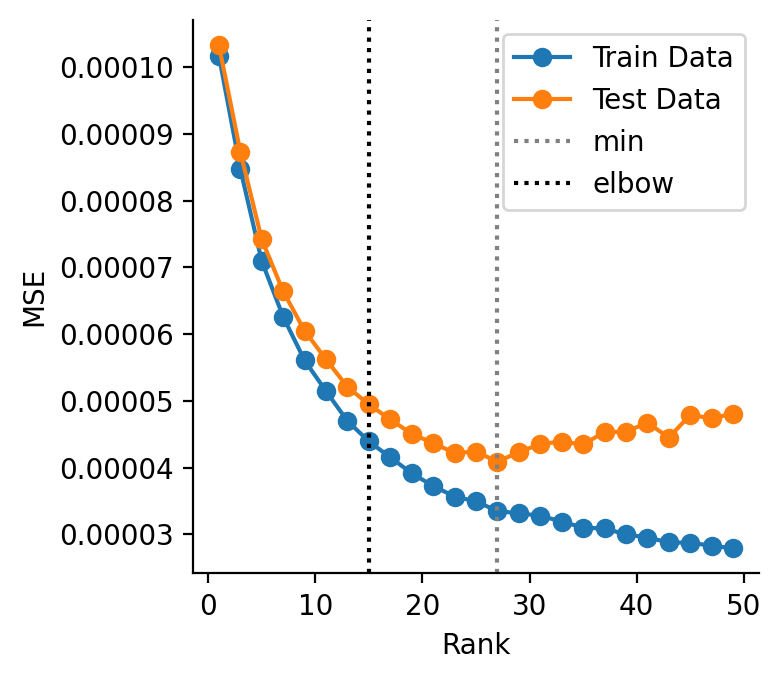

❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz116\2025_06_07_d\videography_processing\preprocessed_tiff.npy


In [53]:
cv_dict_sz116_c = cv_nmf_run_all(data_root, selected_datasets=selected)

In [51]:
# print(cv_dict_sz101['sz101_2025_04_13_b']['test_err'])

In [ ]:
#run cv_nmf batch 
cv_dict = cv_nmf_run_all(data_root)

In [ ]:
np.save('cv_results.npy', cv_dict)
print('Saved cv_results')

In [ ]:
print(cv_dict)

In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(cv_dict, orient='idx')
excel_path = os.path.join(data_root, 'cv_results.xlsx')
df.to_excel(excel_path)
print('Saved in Excel')